# Validation Dataset

## Import Library

In [4]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import copy
import torch
# from PIL import Image
# import pickle
import import_ipynb
sys.path.append(os.pardir)
from DataSet.mnist import load_mnist
from Ch2_3.handWrittenDigit import get_data, init_network, predict, img_show
from Ch2_3.activation_function import softmax, sigmoid
from Ch4.load_error import cross_entropy_error
from Ch6.histogram import MultiLayerNetExtend
from Ch6.training_tech import AdaGrad, SGD

## Shuffle Data

In [6]:
def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.
    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블
    
    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

In [4]:
(x_train, t_train),(x_test, t_test)=\
    load_mnist()

x_train, t_train = shuffle_dataset(x_train, t_train)

validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

In [7]:
class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        # optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
        #                         'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        optimizer_class_dict = {'sgd':SGD}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


In [10]:
def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list

In [10]:
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

val acc:0.96475 | lr:0.0026715682217134883, weight decay:1.0637435014338383e-07
val acc:0.9664166666666667 | lr:0.0028502693875334033, weight decay:4.7058284442528155e-07
val acc:0.9550833333333333 | lr:0.001480149718372345, weight decay:6.545052205716703e-05
val acc:0.2035 | lr:4.4941294484575214e-06, weight decay:1.9153260236050172e-05
val acc:0.0705 | lr:2.1537454035911154e-06, weight decay:1.6552114070926735e-08
val acc:0.47991666666666666 | lr:2.437713480259481e-05, weight decay:7.918658734092255e-07
val acc:0.7833333333333333 | lr:7.8527798575828e-05, weight decay:8.175740123079926e-07
val acc:0.8869166666666667 | lr:0.00016112393790973357, weight decay:1.8661273538123799e-07
val acc:0.96125 | lr:0.0016868188158732005, weight decay:3.9591435997185256e-05
val acc:0.7555833333333334 | lr:5.719505405453593e-05, weight decay:2.524368621865122e-08
val acc:0.94425 | lr:0.0008422677421924291, weight decay:7.631190519086507e-06
val acc:0.11841666666666667 | lr:1.5677472562482714e-06, wei

=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.9711666666666666) | lr:0.008349719704716894, weight decay:1.7577082301602566e-05
Best-2(val acc:0.9708333333333333) | lr:0.007103209331929478, weight decay:6.489765768401611e-08
Best-3(val acc:0.9705) | lr:0.007428010084150745, weight decay:5.462731861360607e-08
Best-4(val acc:0.9704166666666667) | lr:0.00787392681570017, weight decay:5.232109759326611e-07
Best-5(val acc:0.9703333333333334) | lr:0.008982333381531022, weight decay:2.8481794315612704e-06
Best-6(val acc:0.969) | lr:0.007766209539917788, weight decay:6.086774529029649e-05
Best-7(val acc:0.9686666666666667) | lr:0.005410931890831141, weight decay:6.041364474374625e-06
Best-8(val acc:0.9673333333333334) | lr:0.0036780663610558335, weight decay:4.870958113716821e-06
Best-9(val acc:0.967) | lr:0.004959262872239761, weight decay:4.1874195296238215e-07
Best-10(val acc:0.9664166666666667) | lr:0.0028502693875334033, weight decay:4.7058284442528155e-07
Be

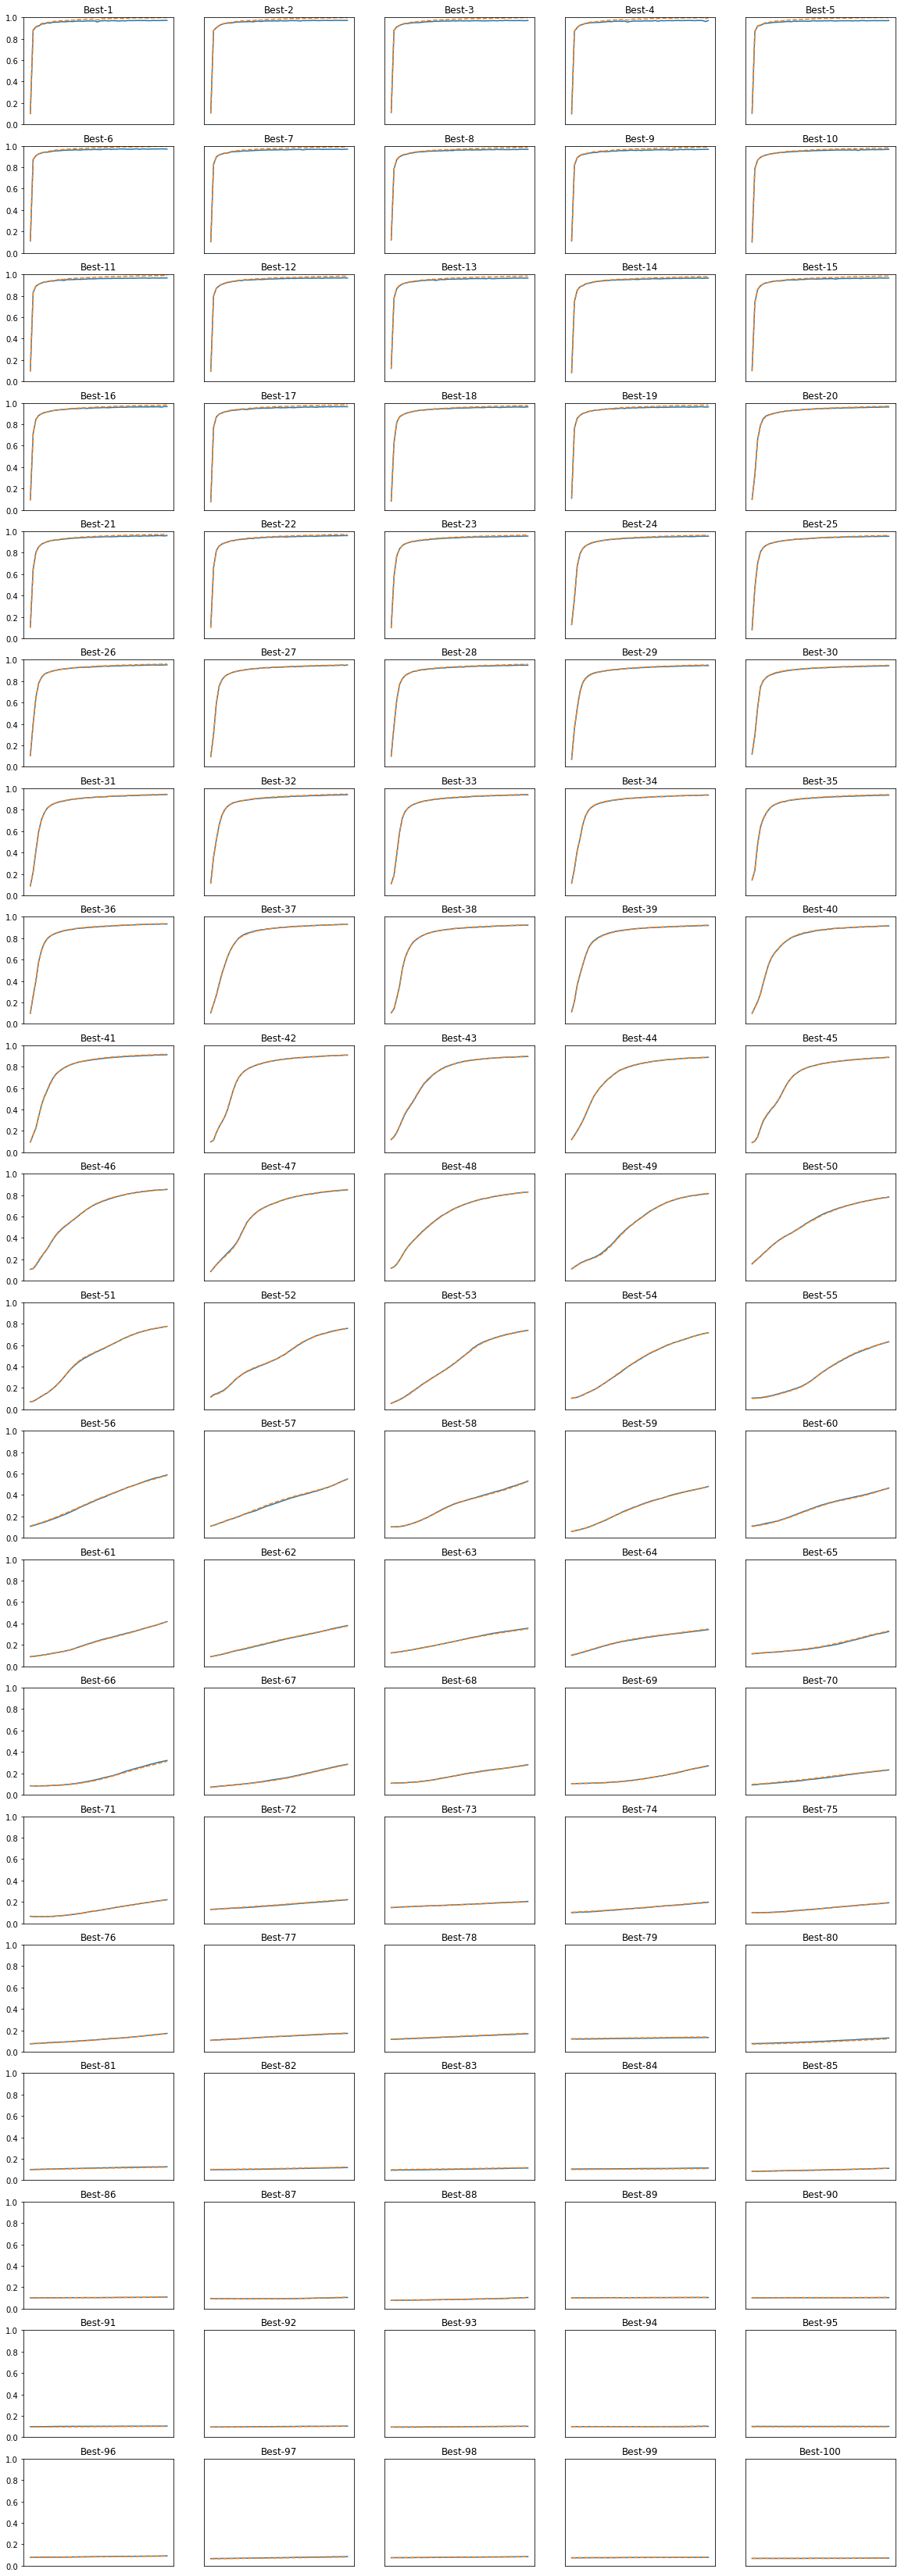

In [27]:
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 100
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0
plt.figure(figsize=(20,60))
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

In [8]:
(x_train, t_train),(x_test, t_test)=\
    load_mnist()

x_train = x_train[:500]
t_train = t_train[:500]

x_train, t_train = shuffle_dataset(x_train, t_train)
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

In [11]:
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

val acc:0.07 | lr:7.973400949383837e-05, weight decay:1.8039514902551865e-06
val acc:0.11 | lr:0.00025096867706548784, weight decay:5.781191253387931e-06
val acc:0.11 | lr:0.00022690498596675875, weight decay:3.8994134422657916e-07
val acc:0.8 | lr:0.006141524328885067, weight decay:1.9084630994750556e-05
val acc:0.16 | lr:3.506781303330414e-05, weight decay:2.4575408460123895e-08
val acc:0.17 | lr:1.1074855217321089e-06, weight decay:2.934679075315174e-07
val acc:0.1 | lr:2.357056308114561e-05, weight decay:9.28024155992958e-08
val acc:0.67 | lr:0.005625867371082439, weight decay:3.943989760641251e-06
val acc:0.38 | lr:0.0033566167334722645, weight decay:7.338870762526881e-08
val acc:0.12 | lr:2.1521671474701845e-06, weight decay:1.3288798933496475e-06
val acc:0.17 | lr:0.0005247261342893814, weight decay:1.4684080343600304e-06
val acc:0.11 | lr:0.00018568669418771616, weight decay:6.440001443458774e-08
val acc:0.86 | lr:0.00900981911637706, weight decay:6.51887945682758e-07
val acc:0

=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.86) | lr:0.00900981911637706, weight decay:6.51887945682758e-07
Best-2(val acc:0.8) | lr:0.006141524328885067, weight decay:1.9084630994750556e-05
Best-3(val acc:0.78) | lr:0.007030793801912591, weight decay:1.0318679822675152e-08
Best-4(val acc:0.77) | lr:0.007900235197871005, weight decay:9.552501890877456e-08
Best-5(val acc:0.73) | lr:0.005700779549336249, weight decay:3.759609442962918e-07
Best-6(val acc:0.67) | lr:0.005625867371082439, weight decay:3.943989760641251e-06
Best-7(val acc:0.6) | lr:0.003466304179666687, weight decay:4.341825027627162e-07
Best-8(val acc:0.6) | lr:0.0036810190908890864, weight decay:1.2839671124162566e-05
Best-9(val acc:0.58) | lr:0.004026190521386577, weight decay:1.6519775759745428e-06
Best-10(val acc:0.53) | lr:0.003384736784558392, weight decay:1.7882653720251158e-07
Best-11(val acc:0.47) | lr:0.0025056247045492698, weight decay:1.5594757309576522e-06
Best-12(val acc:0.46) 

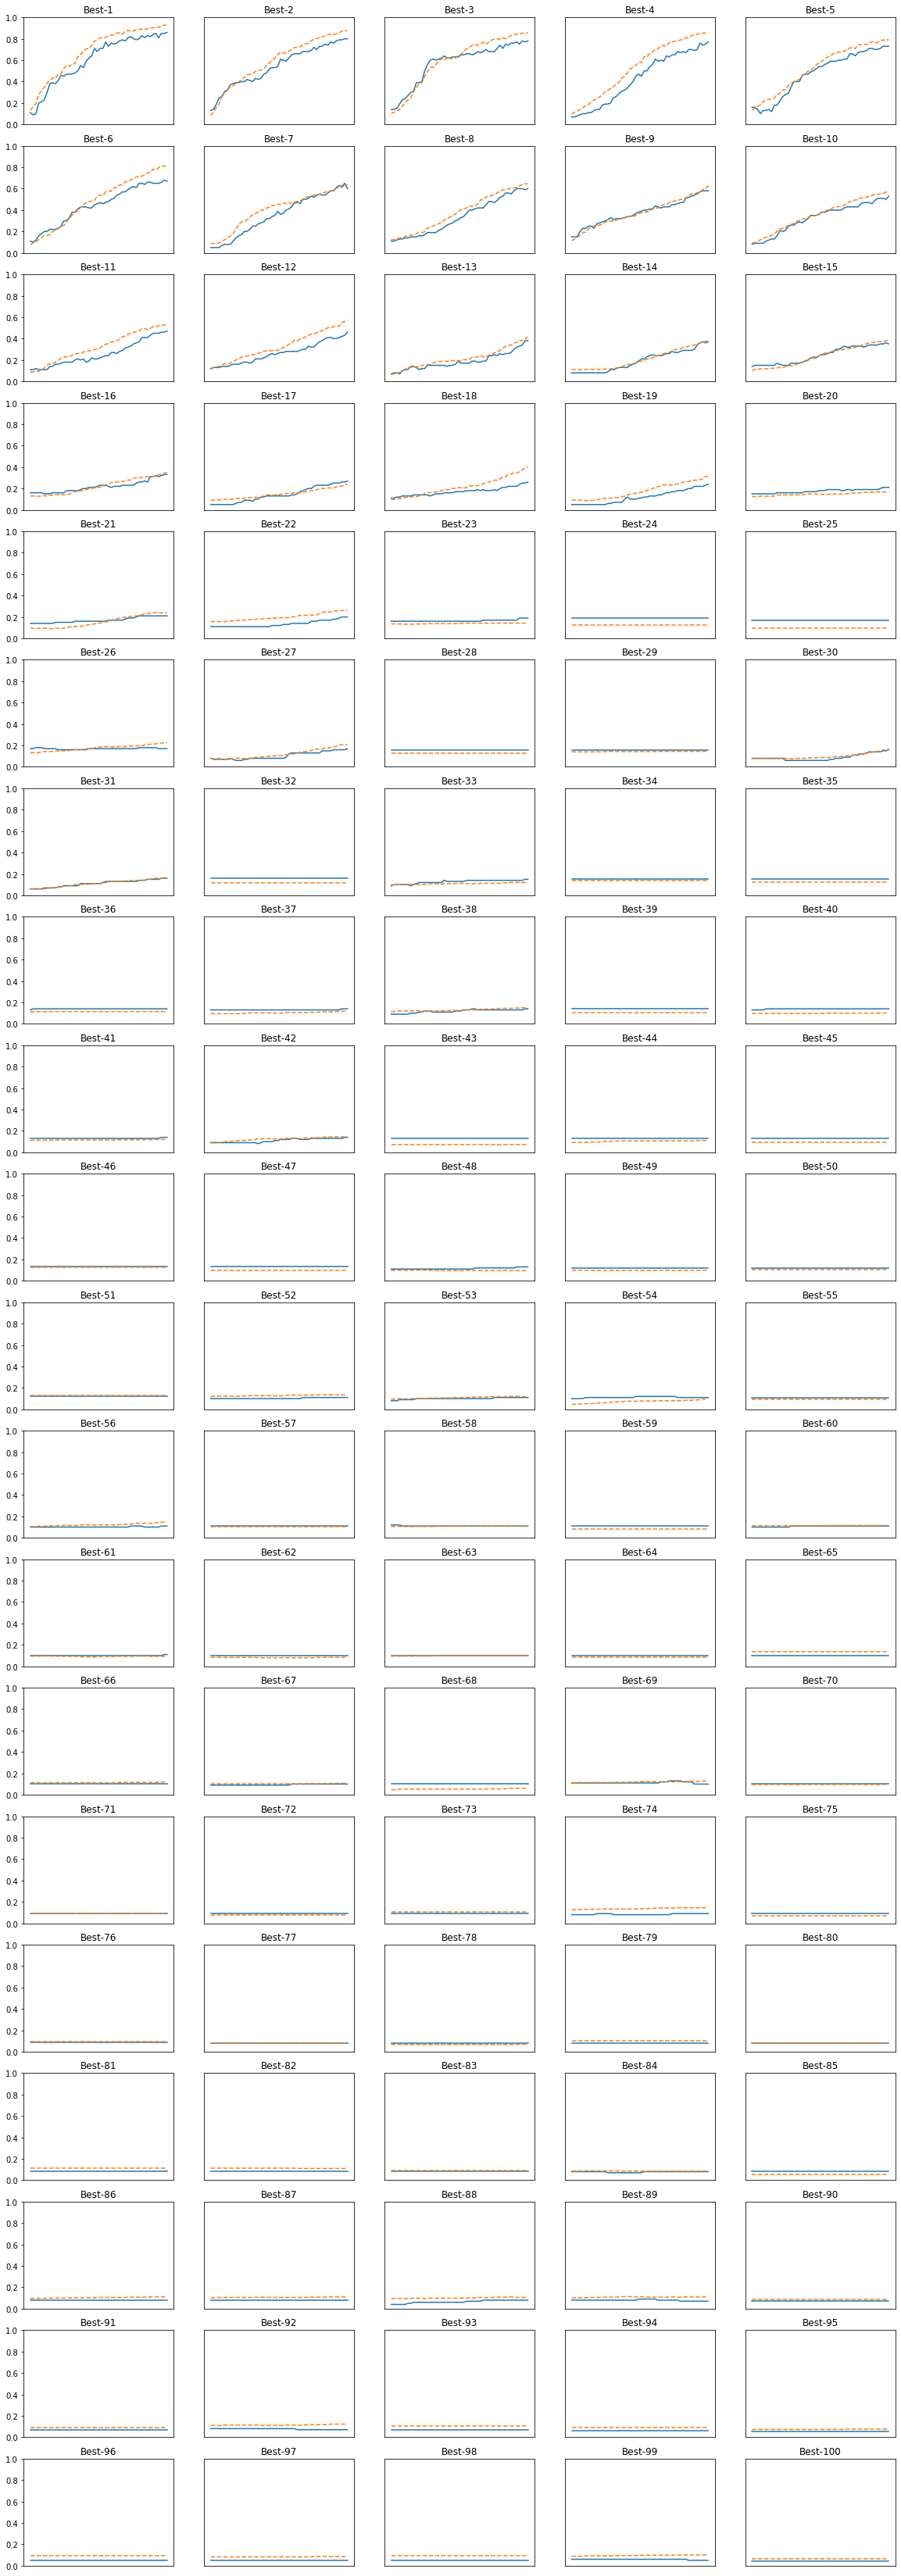

In [12]:
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 100
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0
plt.figure(figsize=(20,60))
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()